In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from colour.appearance import XYZ_to_CIECAM02
from math import cos, sin, sqrt, radians
from colour import SDS_ILLUMINANTS, SpectralShape
from scipy.interpolate import interp1d

In [44]:
shape = SpectralShape(380, 780, 5)
wavelengths = np.arange(shape.start, shape.end + shape.interval, shape.interval)
d65 = SDS_ILLUMINANTS['D65'].copy().align(shape)
d65_values = d65.values


df_d65 = pd.DataFrame({
    'Wavelength': wavelengths,
    'D65': d65_values
})
print(df_d65.head())

df_d65.to_csv('C:/Users/ThinkPad P51/Desktop/d65.csv', index=False)

   Wavelength      D65
0         380  49.9755
1         385  52.3118
2         390  54.6482
3         395  68.7015
4         400  82.7549


In [118]:
def load_spd_excel_resample_to_5nm(path):
    df = pd.read_excel(path)
    df = df.apply(pd.to_numeric, errors='coerce')
    df = df.dropna()  

    wavelengths_1nm = df.iloc[:, 0].values 
    spd_values_1nm = df.iloc[:, 1].values  

    interp_func = interp1d(wavelengths_1nm, spd_values_1nm, kind='linear', bounds_error=False, fill_value=0)
    wavelengths_5nm = np.arange(380, 781, 5)
    spd_values_5nm = interp_func(wavelengths_5nm)

    return dict(zip(wavelengths_5nm, spd_values_5nm))


def load_d65_csv(path):
    df = pd.read_csv(path) 
    df = df.apply(pd.to_numeric, errors='coerce')  
    df = df.fillna(0)
    return dict(zip(df['Wavelength'], df['D65']))

    
def load_ces_dat(path):
    data = np.loadtxt(path, delimiter=',')
    wavelengths = data[:, 0]
    sample_values = data[:, 1:]
    ces_samples = []
    for i in range(sample_values.shape[1]):
        sample = dict(zip(wavelengths, sample_values[:, i]))
        ces_samples.append(sample)
    return ces_samples

def load_cmf_csv(path):
    df = pd.read_csv(path)
    # 取 380, 385, 390 ... 780的波长索引
    wavelengths = np.arange(380, 781, 5)
    cmf = {}
    for wl in wavelengths:
        i = wl - 380  # 因为df的行索引对应波长 - 380
        cmf[wl] = (df.loc[i, 'x_bar'], df.loc[i, 'y_bar'], df.loc[i, 'z_bar'])
    return cmf




In [99]:
def downsample_ces(ces_samples, step=5):
    downsampled = []
    for ces in ces_samples:  # 这里每个ces本身就是字典，不解包
        new_ces = {wl: ces[wl] for wl in range(380, 781, step)}
        downsampled.append(new_ces)
    return downsampled

In [151]:
def compute_XYZ(spd, reflectance, cmfs):
    wavelengths = np.arange(380, 781, 5)
    d_lambda = 5
    X = Y = Z = 0.0
    for wl in wavelengths:
        S = spd.get(wl, 0)
        R = reflectance.get(wl, 0)
        x_bar, y_bar, z_bar = cmfs.get(wl, (0, 0, 0))
        X += S * R * x_bar
        Y += S * R * y_bar
        Z += S * R * z_bar
    k = 100 / (sum(spd.get(wl, 0) * cmfs.get(wl, (0, 0, 0))[1] * d_lambda for wl in wavelengths))
    X *= k * d_lambda
    Y *= k * d_lambda
    Z *= k * d_lambda
    return [X, Y, Z]


In [24]:
def cam02_jmh_to_ab(J, M, h):
    h_rad = np.deg2rad(h)
    a = M * np.cos(h_rad)
    b = M * np.sin(h_rad)
    return a, b

In [148]:
def ciecam02_to_ucs(J, a, b):
    # 2006 CAM02-UCS conversion公式
    c1 = 0.007
    c2 = 0.0228
    c3 = 1.0

    Jp = (1 + 100 * c1) * J / (1 + c1 * J)
    ap = c2 * a
    bp = c2 * b
    return np.array([Jp, ap, bp])

In [153]:
def color_differences(jab1, jab2):
    return np.linalg.norm(jab1 - jab2, axis=1)

def compute_Rf_Rg(delta_Es, jab_test):
    Rf = 100 - 4.6 * np.mean(delta_Es)
    a = jab_test[:, 1]
    b = jab_test[:, 2]
    chroma = np.sqrt(a**2 + b**2)
    Rg = 100 * (np.std(chroma) / np.mean(chroma))
    return Rf, Rg

In [164]:
def main(spd_path, d65_path, ces_path, cmf_path):
    spd_test = load_spd_excel_resample_to_5nm(spd_path)
    d65_def = load_d65_csv(d65_path) #未转化为相对单位前
    ces_samples_1nm = load_ces_dat(ces_path)
    ces_samples = downsample_ces(ces_samples_1nm) #间隔5nm

    cmfs = load_cmf_csv(cmf_path)

    wavelengths = sorted(spd_test.keys())
    spd_array = np.array([spd_test[wl] for wl in wavelengths])
    d65_array = np.array([d65_def[wl] for wl in wavelengths])

    d65_scaled = d65_array * (np.sum(spd_array) / np.sum(d65_array))  #单位转化

    d65 = dict(zip(wavelengths, d65_scaled)) #再转为dict

    #归一化
    max_spd = max(spd_test.values())
    spd_norm = {wl: val / max_spd for wl, val in spd_test.items()}
    max_d65 = max(d65_def.values())
    d65_norm = {wl: val / max_d65 for wl, val in d65_def.items()}
    
    

    XYZ_test_list, XYZ_ref_list = [], []
    
    for sample in ces_samples:
        xyz_test = compute_XYZ(spd_norm, sample, cmfs)
        xyz_ref  = compute_XYZ(d65_norm, sample, cmfs)
        XYZ_test_list.append(xyz_test)
        XYZ_ref_list.append(xyz_ref)

    # CIECAM02 参数（假设 viewing conditions）
    XYZ_w = compute_XYZ(d65_norm, {wl: 1.0 for wl in range(380, 781, 5)}, cmfs)
    print("White point XYZ:", XYZ_w)
    cam_test = [XYZ_to_CIECAM02(xyz, XYZ_w=XYZ_w, L_A=64, Y_b=20) for xyz in XYZ_test_list]
    cam_ref  = [XYZ_to_CIECAM02(xyz, XYZ_w=XYZ_w, L_A=64, Y_b=20) for xyz in XYZ_ref_list]


    jab_test = np.array([
    ciecam02_to_ucs(cam.J, *cam02_jmh_to_ab(cam.J, cam.M, cam.h))
    for cam in cam_test
    ])
    jab_ref = np.array([
    ciecam02_to_ucs(cam.J, *cam02_jmh_to_ab(cam.J, cam.M, cam.h))
    for cam in cam_ref
    ])


    def plot_cam02_ucs_distribution(jab_test, jab_ref):
     # 提取 a', b' 分量
     a_test, b_test = jab_test[:, 1], jab_test[:, 2]
     a_ref, b_ref = jab_ref[:, 1], jab_ref[:, 2]

     plt.figure(figsize=(8, 8))
     plt.scatter(a_ref, b_ref, c='blue', label='D65', alpha=0.6)
     plt.scatter(a_test, b_test, c='red', label='Test Light Source', alpha=0.6)

     # 可视化连接线以展示色差方向
     for i in range(len(a_ref)):
        plt.plot([a_ref[i], a_test[i]], [b_ref[i], b_test[i]], c='gray', alpha=0.3, linewidth=0.5)

     plt.axhline(0, color='black', linewidth=0.8)
     plt.axvline(0, color='black', linewidth=0.8)

     plt.xlabel("a′")
     plt.ylabel("b′")
     plt.title("CAM02-UCS Color Distribution")
     plt.legend()
     plt.grid(True)
     plt.axis('equal')
     plt.tight_layout()
     plt.show()
#蓝色点：参考光源下的色样分布（如 D65）

#红色点：测试光源下的色样分布。

#灰色连线：同一个色样在参考光源和测试光源下的色彩偏移方向和大小。

#越密集地围绕原点对称、越小的 ΔE，说明光源色彩还原能力越好（Rf 越高）
     # 调用绘图函数
    plot_cam02_ucs_distribution(jab_test, jab_ref)

    delta_E = color_differences(jab_test, jab_ref)
    Rf, Rg = compute_Rf_Rg(delta_E, jab_test)
    
    print(f"Rf (Fidelity Index): {Rf:.2f}")
    print(f"Rg (Gamut Index): {Rg:.2f}")

White point XYZ: [95.042966939935269, 99.999999999999901, 108.88005467036128]


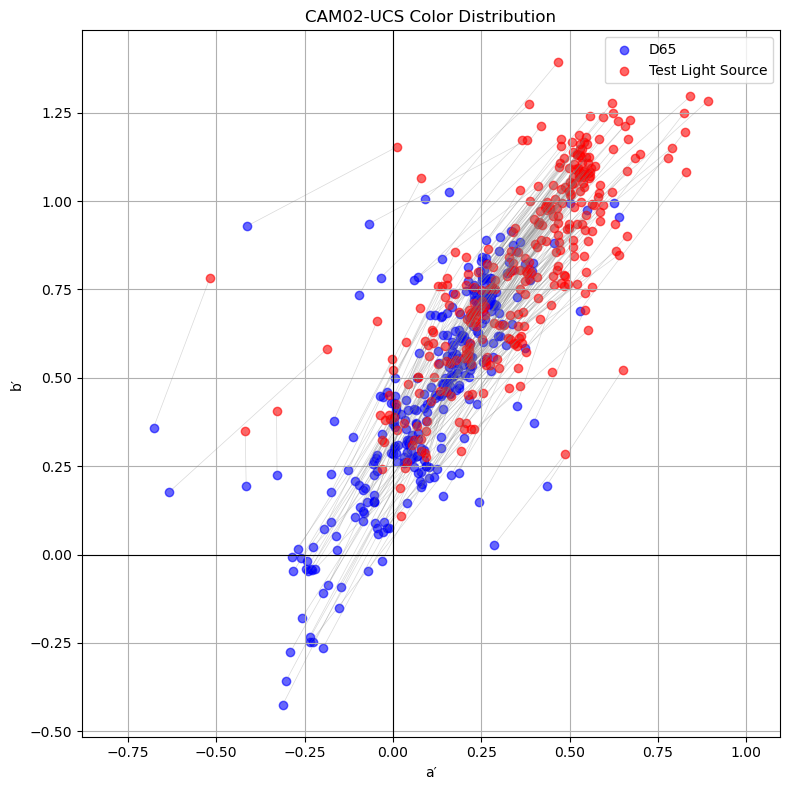

[ 0.49739463  0.68326652  1.12884006  1.62352991  0.53411089  0.5996462
  0.52051145  0.87773546  1.14368467  1.32657879] 2.20025278919
Rf (Fidelity Index): 89.88
Rg (Gamut Index): 34.46


In [165]:
main(
    spd_path='P1_processed_data.xlsx',
    d65_path='d65.csv',
    ces_path='IESTM30_15_Sspds.dat',
    cmf_path='cmf.csv'
)